# Scores

In Monte-Carlo particle transport simulations, a score is a computed quantity that provides information about the behavior of particles within the simulation. Scores are used to analyze various aspects of particle transport, such as flux, reaction rates, k-effective, and more.

The `tripoli5.score` module is a submodule of Tripoli-5, serving as the main entry point for defining and managing scores within the `simulation`. This module allows you to declare the scores you want to compute, manage them during the simulation, and retrieve the results after the simulation is complete.


## Types of Scores

The `tripoli5.score` module provides a variety of scores, each designed to compute specific quantities of interest. Below is an overview of the different score classes available in this module.

1. **Flux Scores**: Compute the particle flux, which is the number of particles crossing a unit area per unit time.

   - `FluxSpectrumCollGeneral`:  **space integrated** flux spectrum using the **collision** estimator.
   - `FluxSpectrumTrackGeneral`:  **space integrated** flux spectrum using the **track** estimator.
   - `FluxSpectrumAllVolumes`: flux spectrum for **each volume** using the **track** estimator.
   - `FluxSpectrumCollAllVolumes`: flux spectrum for **each volume** using the **collision** estimator.
   - `FluxSpectrumCollMEDMesh`: flux spectrum over a MedCoupling mesh using the **collision** estimator.

2. **Reaction Rate Scores**: Compute the number of reactions occurring per unit volume per unit time.

   - `MTReactionRate`: Computes MT reaction rate scores for all volumes.

3. **Kappa Fission Scores**: Compute the energy released per fission event.

   - `KappaFissionAllVolumes`: Computes the kappa fission scores for all volumes.
   - `KappaFissionMEDMesh`: Computes the kappa fission scores for a MedCoupling mesh using the **collision** estimator.

4. **K-effective Scores**: Compute the effective multiplication factor (K-effective) of neutrons in a reactor.

   - `KStep`: Computes K-step scores.

Scores are computed using different types of estimators, which are methods for calculating the quantities of interest. The estimators include:

- **Track Estimator**: Integrates contributions along the particle's path, suitable for computing path-dependent quantities like flux.
- **Collision Estimator**: Sums contributions at collision points, suitable for computing collision-dependent quantities like reaction rates.

We will describe the various score with an example configuration. 

## Setting up a Configuration

In this example, we will use the [Jezebel](../criticality/Jezebel.ipynb) configuration consisting of a sphere. The sphere has been artificially divided into two spherical shells (an inner and an outer shell) leading to three volumes: one inner shell, one outer shell (labeled "pu_inner" and "pu_outer") and one outside (labeled "void_volume").  
The material composition is a highly enriched Plutonium (Pu). See the following notebookes for details for constructing a [geometry](agora_geometry.ipynb), defining a [material composition](materials_compositions.ipynb) and setting up the [physics options](neutron_media.ipynb), defining the [source](source.ipynb). 

In [1]:
%load_ext wurlitzer

In [2]:
import tripoli5
from tripoli5.core.physics import Temperature, Density
from tripoli5.core.physics import ParticleType
from tripoli5.core.literals import K, MeV, gPerCm3
from tripoli5.core.euclide import Direction, Point

# Define a sphere centered at the origin with a radius of 6.39157
center_sphere = tripoli5.agora.Sphere(Point(0.0, 0.0, 0.0), 6.39157 / 2.0)
sphere = tripoli5.agora.Sphere(Point(0.0, 0.0, 0.0), 6.39157)

# Define a volume inside the sphere with the material "Pu"
pu_inner_volume = tripoli5.agora.Volume(
    shape=tripoli5.agora.Shape(-center_sphere), material="Pu", label="pu_inner"
)
pu_outer_volume = tripoli5.agora.Volume(
    shape=tripoli5.agora.Shape(+center_sphere & -sphere),
    material="Pu",
    label="pu_outer",
)

# Define a volume outside the sphere (void volume)
void_volume = tripoli5.agora.Volume.outside(
    shape=tripoli5.agora.Shape(+sphere), label="void_volume"
)

# Create the geometry with the defined volumes
geo = tripoli5.agora.Geometry(
    tripoli5.agora.Universe([pu_inner_volume, pu_outer_volume, void_volume])
)
# Load the nuclear data catalog from the environment variable
catalog = tripoli5.delos.Catalog.fromFile(
    f"/opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/endfb8r0_mcnp_v{tripoli5.delos.CATALOG_VERSION}.yaml"
)
# Define a material mixture for Plutonium (Pu)
Pu = (
    tripoli5.materials.MixtureBuilder(
        "concentrations"
    )  # Initialize the mixture builder with concentration mode
    .withName("Pu")  # Set the name of the material to "Pu"
    .withCatalog(catalog)  # Associate the nuclear data catalog with the material
    .withTemperature(294 * K)  # Set the temperature of the material to 294 Kelvin
    .add(
        ["PU239", "PU240", "PU241", "GA69", "GA71"],  # Add isotopes to the mixture
        [
            0.037047,
            0.0017512,
            0.00011674,
            0.00083603,
            0.00053917,
        ],  # Specify the concentrations of the isotopes
    )
    .build()  # Build the material mixture
)

# Initialize the NeutronMediumBuilder and build the media
media = (
    tripoli5.materials.NeutronMediumBuilder()
    .withCatalog(catalog)
    .withMixtures([Pu])
    .withURR("ace")
    .build()
)
src = tripoli5.source.PointIsotropicSource(
    ParticleType("Neutron"),
    tripoli5.distributions.energy.MonoKinetic(2.0 * MeV),
    Point(0.0, 0.0, 0.0),
)
param = tripoli5.simulation.SimulationParameters(
    nb_cycles=110,
    nb_events=10000,  # Particles per cycle
    name="Score_notebook",
    nb_threads=20,
    discard=10,
)

[2025-08-07 13:01:12.953] [info] Loading catalog from file: /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/endfb8r0_mcnp_v2.2.0.yaml
[2025-08-07 13:01:12.995] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/mass/njoy_ace/v0.2.0/archive/wrapped_mass_data.bin
[2025-08-07 13:01:13.000] [info] Building GA69 at temperatures: TemperatureRange([294 [K], 2.5334957256000003e-08 [MeV], 20.850000000000023 [°C]])
[2025-08-07 13:01:13.002] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/freegas/njoy_ace/v0.11.0/dir/GA69.294.bin
[2025-08-07 13:01:13.008] [info]   Building free gas collisions at temperature 294 [K], 2.5334957256000003e-08 [MeV], 20.850000000000023 [°C]
[2025-08-07 13:01:13.008] [info]   Building reaction MTs = 60, 72, 2, 61, 57, 28, 54, 55, 59, 62, 32, 91, 63, 64, 65, 53, 66, 67, 68, 69, 70, 58, 71, 56, 73, 102, 74, 103, 51, 22, 111, 52, 104, 16, 75, 105, 107, 106
[2025-08-07 13:01:13.008] [info] Building GA71 at temperatures: TemperatureRange([294 [K], 2.533495725600

## Score Declaration

Before running a simulation, you need to declare the scores you want to compute. This involves specifying the type of score using the constructor of the appropriate class and providing any necessary parameters for the computation. Each score type comes with a pre-configured estimator designed for its specific needs. Here is an example of how to declare scores:

### Flux Spectrum Scores

#### Volume-based scores

In [3]:
# Define the parameters for the flux spectrum scores
nbvols = geo.nb_volumes  # Number of volumes
energy_min = 1e-11  # Minimum energy
energy_max = 20.0  # Maximum energy
nb_groups = 1000  # Number of energy bins

mesh_281g = [
    2.00000e01,
    1.49200e01,
    1.38400e01,
    1.16200e01,
    1.00000e01,
    9.04840e00,
    8.18700e00,
    7.40800e00,
    6.70300e00,
    6.06530e00,
    4.96600e00,
    4.06580e00,
    3.32870e00,
    2.72530e00,
    2.23100e00,
    1.90100e00,
    1.63650e00,
    1.40580e00,
    1.33700e00,
    1.28700e00,
    1.16200e00,
    1.05100e00,
    9.51100e-01,
    8.60000e-01,
    7.06500e-01,
    5.78000e-01,
    4.94000e-01,
    4.56000e-01,
    4.12500e-01,
    3.83900e-01,
    3.20600e-01,
    2.67800e-01,
    2.30000e-01,
    1.95000e-01,
    1.65000e-01,
    1.40000e-01,
    1.22800e-01,
    1.15620e-01,
    9.46650e-02,
    8.23000e-02,
    6.73800e-02,
    5.51700e-02,
    4.99200e-02,
    4.08700e-02,
    3.69800e-02,
    3.34590e-02,
    2.92800e-02,
    2.73900e-02,
    2.61000e-02,
    2.50000e-02,
    2.27000e-02,
    1.85800e-02,
    1.62000e-02,
    1.49000e-02,
    1.36036e-02,
    1.11378e-02,
    9.11900e-03,
    7.46600e-03,
    6.11200e-03,
    5.00400e-03,
    4.09700e-03,
    3.48100e-03,
    2.99600e-03,
    2.57900e-03,
    2.21900e-03,
    1.91000e-03,
    1.61400e-03,
    1.34500e-03,
    1.13500e-03,
    1.06500e-03,
    9.07500e-04,
    7.48500e-04,
    6.14600e-04,
    5.03200e-04,
    4.10796e-04,
    3.53575e-04,
    3.19928e-04,
    2.83751e-04,
    2.41796e-04,
    1.97966e-04,
    1.62081e-04,
    1.32701e-04,
    1.08646e-04,
    8.89519e-05,
    7.50456e-05,
    6.14421e-05,
    5.26726e-05,
    4.62516e-05,
    4.35842e-05,
    4.01690e-05,
    3.37200e-05,
    2.76077e-05,
    2.45900e-05,
    2.25243e-05,
    2.23780e-05,
    2.21550e-05,
    2.20012e-05,
    2.17018e-05,
    2.14859e-05,
    2.13360e-05,
    2.12296e-05,
    2.11448e-05,
    2.10604e-05,
    2.09764e-05,
    2.07676e-05,
    2.06847e-05,
    2.06022e-05,
    2.05199e-05,
    2.04176e-05,
    2.02751e-05,
    2.00734e-05,
    1.95974e-05,
    1.93927e-05,
    1.91997e-05,
    1.90849e-05,
    1.79591e-05,
    1.77591e-05,
    1.75648e-05,
    1.74457e-05,
    1.68305e-05,
    1.65502e-05,
    1.60498e-05,
    1.57800e-05,
    1.48663e-05,
    1.47301e-05,
    1.45952e-05,
    1.44703e-05,
    1.42506e-05,
    1.40510e-05,
    1.35461e-05,
    1.33297e-05,
    1.26000e-05,
    1.24721e-05,
    1.23086e-05,
    1.21302e-05,
    1.19795e-05,
    1.18153e-05,
    1.17094e-05,
    1.15895e-05,
    1.12695e-05,
    1.10529e-05,
    1.08038e-05,
    1.05793e-05,
    9.50004e-06,
    9.14032e-06,
    8.97996e-06,
    8.80039e-06,
    8.67370e-06,
    8.52408e-06,
    8.30033e-06,
    8.13028e-06,
    7.97009e-06,
    7.83966e-06,
    7.73995e-06,
    7.60036e-06,
    7.38001e-06,
    7.13988e-06,
    6.99430e-06,
    6.91800e-06,
    6.87000e-06,
    6.83500e-06,
    6.81100e-06,
    6.79200e-06,
    6.77600e-06,
    6.76000e-06,
    6.74200e-06,
    6.71700e-06,
    6.63100e-06,
    6.60600e-06,
    6.58800e-06,
    6.57200e-06,
    6.55600e-06,
    6.53900e-06,
    6.51500e-06,
    6.48200e-06,
    6.43200e-06,
    6.36000e-06,
    6.28000e-06,
    6.16000e-06,
    6.06000e-06,
    5.96000e-06,
    5.80000e-06,
    5.72000e-06,
    5.62000e-06,
    5.53000e-06,
    5.48800e-06,
    5.41000e-06,
    5.38000e-06,
    5.32000e-06,
    5.21000e-06,
    5.11000e-06,
    4.93300e-06,
    4.76800e-06,
    4.42000e-06,
    4.31000e-06,
    4.22000e-06,
    4.00000e-06,
    3.88200e-06,
    3.71200e-06,
    3.54300e-06,
    3.14200e-06,
    2.88400e-06,
    2.77500e-06,
    2.74100e-06,
    2.72000e-06,
    2.70000e-06,
    2.64000e-06,
    2.62000e-06,
    2.59000e-06,
    2.55000e-06,
    2.47000e-06,
    2.33000e-06,
    2.27300e-06,
    2.21700e-06,
    2.15700e-06,
    2.07000e-06,
    1.99000e-06,
    1.90000e-06,
    1.78000e-06,
    1.66900e-06,
    1.58800e-06,
    1.52000e-06,
    1.44400e-06,
    1.41000e-06,
    1.38100e-06,
    1.33100e-06,
    1.29300e-06,
    1.25100e-06,
    1.21400e-06,
    1.17000e-06,
    1.14800e-06,
    1.13000e-06,
    1.11600e-06,
    1.10400e-06,
    1.09200e-06,
    1.07800e-06,
    1.03500e-06,
    1.02100e-06,
    1.00900e-06,
    9.96500e-07,
    9.82000e-07,
    9.64000e-07,
    9.44000e-07,
    9.20000e-07,
    8.80000e-07,
    8.10000e-07,
    7.00000e-07,
    6.25000e-07,
    5.95000e-07,
    5.55000e-07,
    5.20000e-07,
    4.75000e-07,
    4.31600e-07,
    3.90000e-07,
    3.53000e-07,
    3.25000e-07,
    3.05000e-07,
    2.80000e-07,
    2.55000e-07,
    2.31200e-07,
    2.09600e-07,
    1.90000e-07,
    1.61900e-07,
    1.38000e-07,
    1.20000e-07,
    1.04300e-07,
    8.98000e-08,
    7.65000e-08,
    6.52000e-08,
    5.55000e-08,
    4.73000e-08,
    4.03000e-08,
    3.44000e-08,
    2.93000e-08,
    2.49400e-08,
    2.00100e-08,
    1.48300e-08,
    1.04500e-08,
    7.14500e-09,
    4.55600e-09,
    2.50000e-09,
    1.00000e-11,
]
mesh_281g.sort()
# Create an instance of FluxSpectrumCollGeneral
flux_spect_general = tripoli5.score.FluxSpectrumCollGeneral(
    mesh_281g, "Integrated Flux over 281g"
)

# Create an instance of FluxSpectrumAllVolumes
flux_all_volumes = tripoli5.score.FluxSpectrumAllVolumes(
    nbvols, energy_min, energy_max, nb_groups, "FluxSpectrumAllVolumes"
)

# Create an instance of FluxSpectrumCollAllVolumes
flux_coll_all_volumes = tripoli5.score.FluxSpectrumCollAllVolumes(
    nbvols, energy_min, energy_max, nb_groups, "FluxSpectrumCollAllVolumes"
)

#### Mesh-based Scores

We define here a MEDCoupling Cartesian mesh to demonstrate mesh-based scores.  
The flux will be computed over this mesh.

In [4]:
import medcoupling as mc
import numpy as np

# Define the length
length = 6.39157 * 1.3

# Create the coordinate arrays
xarr = mc.DataArrayDouble(
    np.linspace(start=-length, stop=length, num=10, endpoint=True)
)
yarr = mc.DataArrayDouble(
    np.linspace(start=-length, stop=length, num=10, endpoint=True)
)
zarr = mc.DataArrayDouble(
    np.linspace(start=-length, stop=length, num=10, endpoint=True)
)

# Create the MEDCouplingCMesh
mesh = mc.MEDCouplingCMesh.New("mesh")
mesh.setCoords(xarr, yarr, zarr)
# Create an instance of FluxSpectrumCollMEDMesh
flux_coll_mesh = tripoli5.score.FluxSpectrumCollMEDMesh(
    mesh, energy_min, energy_max, nb_groups, "FluxSpectrumCollMEDMesh"
)

### Reaction Rate Scores

The `MTReactionRate` class is used to compute MT reaction rate scores.

Define MT reaction rates for total, capture and fission rates over an energy grid of 1000 groups defined with equivalent bins in lethargy using NumPy.

In [5]:
mt_reaction_rate = tripoli5.score.MTReactionRate(
    media=media,
    mt_numbers=[tripoli5.delos.ReactionId(mt_number) for mt_number in [1, 102, 18]],
    nb_volumes=geo.nb_volumes,  # number of volumes
    energy_bounds=[e * MeV for e in np.logspace(-11, np.log(20), 1001)],
    name="MTRates",
)

### Kappa Fission Scores

Fission-weighted Q-value (also knowns as kappa or κ; can be used as a rough ersatz for energy deposition)

#### Volume Scores

In [6]:
kappa_fission_vol = tripoli5.score.KappaFissionAllVolumes(
    media, nbvols, energy_min, energy_max, nb_groups, "KappaFissionAllVolumes"
)

#### Mesh-based Scores

The `KappaFissionMEDMesh` class is used to compute kappa fission scores on a mesh.

In [7]:
kappa_fission_mesh = tripoli5.score.KappaFissionMEDMesh(
    mesh=mesh,
    neutron_media=media,
    energy_min=1e-11,
    energy_max=20.0,
    nb_groups=100,
    name="KappaFissionMEDMesh",
)

### Score Manager

The `ScoreManager` class is used to manage the declared scores during the simulation. First, instantiate a `ScoreManager` object using the constructor. Then, add scores using the `addScore` method. Before transmitting the score manager to the simulation, initialize it using the `initialize` method.

It is also possible to reset the score manager using the `reset` method. After the simulation, you can retrieve a score by index using the `getScore` method.


In [8]:
# Instantiate the ScoreManager object with a name for the score set
score_mgr = tripoli5.score.ScoreManager("neutron_simulation_scores")

# Add all scores previously declared for computing them during the simulation
score_mgr.addScore(flux_spect_general)
score_mgr.addScore(flux_all_volumes)
score_mgr.addScore(flux_coll_all_volumes)
score_mgr.addScore(flux_coll_mesh)
score_mgr.addScore(mt_reaction_rate)
score_mgr.addScore(kappa_fission_vol)
score_mgr.addScore(kappa_fission_mesh)
# Initialize the score manager before transmitting it to the simulation
score_mgr.initialize("")

## Configure and Run Simulation

Finally we assemble the calculation using a simulation object. We also need to provide additional, specific calculation settings:

In [9]:
simu = (
    tripoli5.simulation.SimulationBuilder(
        simulation_mode="criticality", parallelism_type="openmp"
    )
    .withSource(src)
    .withGeometry(geo)
    .withMedia("Neutron", media)
    .withParameters(param)
    .withScores(score_mgr)
    .build()
)
simu.run()

[2025-08-07 13:01:13.376] [info] *** Beginning of simulation ***
[2025-08-07 13:01:13.386] [info] Cycle: 1 of 110
[2025-08-07 13:01:13.428] [info]   kstep = 1.38180
[2025-08-07 13:01:13.428] [info]   Mean number of collisions: 1.7696
[2025-08-07 13:01:13.429] [info] Cycle: 2 of 110
[2025-08-07 13:01:13.460] [info]   kstep = 1.12630
[2025-08-07 13:01:13.460] [info]   Mean number of collisions: 1.7399
[2025-08-07 13:01:13.461] [info] Cycle: 3 of 110
[2025-08-07 13:01:13.489] [info]   kstep = 1.05080
[2025-08-07 13:01:13.489] [info]   Mean number of collisions: 1.5624
[2025-08-07 13:01:13.490] [info] Cycle: 4 of 110
[2025-08-07 13:01:13.518] [info]   kstep = 1.02550
[2025-08-07 13:01:13.518] [info]   Mean number of collisions: 1.4953
[2025-08-07 13:01:13.519] [info] Cycle: 5 of 110
[2025-08-07 13:01:13.545] [info]   kstep = 1.02270
[2025-08-07 13:01:13.545] [info]   Mean number of collisions: 1.4909
[2025-08-07 13:01:13.546] [info] Cycle: 6 of 110
[2025-08-07 13:01:13.571] [info]   kstep 

## Score Results

After running the simulation, you will want to retrieve the computed scores. Several common methods and properties are available across all score classes to help you access the results.

**Common Methods**

- `writeToFile(...)`: Writes the results into a CSV file.

**Read-only Properties**

- `mean`: Provides the mean value of the score.
- `var`: Provides the variance of the score.
- `shape`: Retrieves the number of bins for each dimension.
- `energy_bounds`: retrieve the energy binning when applicable (for instance: `MTReactionRate` or `FluxSpectrumCollGeneral`)


Some specific methods are also available for **mesh-based** score results:

- `writeFieldToVTKFile(...)`: Writes the field to a VTK file.
- `writeToMEDFile(...)`: Writes the results to a MED file.

### KStep Results

The k-effective value is computed by default in criticality simulations, so there is no need to declare it in the score manager.
To retrieve the `KStep` results computed during the simulation, you can use the simulation methods `getKstep()`. The `KStep` class also provides a reset method.


In [10]:
# Alternatively, retrieve the KStep score using the getKStep method
kstep = simu.getKStep()
# Calculate the mean value of the KStep score
mean = kstep.mean
# Calculate the standard deviation of the KStep score
std = np.sqrt(kstep.var)
# Print the k-effective value with its standard deviation
print(f"k-eff: {mean}±{std}")

k-eff: [0.99892]±[0.00162455]


### Volume-based Score Results

Results can be retrieve using the `mean` and `var` attributes of each score. The shape of the array can be retrieved using the `shape` attribute.  
The data returned by `mean` and `var` comply to the numpy's [array protocol](https://numpy.org/doc/2.1/reference/arrays.interface.html) and thus can be used as numpy arrays. 

*Note*: Results can also be printed in an ASCII file using the `writeToFile` method of scores objects.

Below we will retrieve the geometry integrated flux spectrum and plot it 

Shape of flux_spect_general: [281]


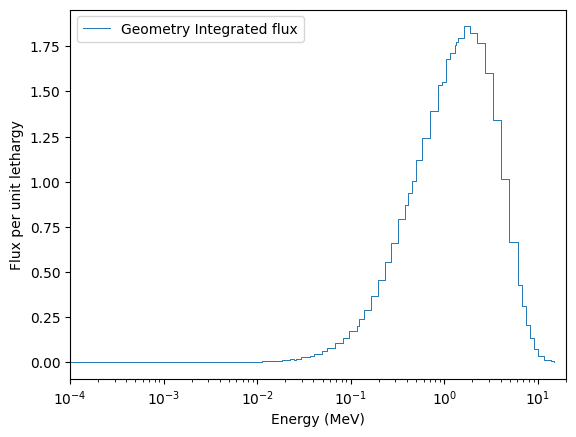

In [11]:
import matplotlib.pyplot as plt

print(f"Shape of flux_spect_general: {flux_spect_general.shape}")

mean_flux = flux_spect_general.mean
energy_binning = flux_spect_general.energy_bounds
flux_per_lethargy = mean_flux / np.ediff1d(np.log(energy_binning))
plt.plot(
    energy_binning[:-1],
    flux_per_lethargy,
    linestyle="-",
    linewidth=0.7,
    drawstyle="steps-post",
    label=f"Geometry Integrated flux",
)
plt.xlabel("Energy (MeV)")
plt.ylabel("Flux per unit lethargy")
plt.xlim(1e-4, 20)
plt.xscale("log")
plt.legend()

Shape of FluxSpectrumAllVolumes: [3, 1000]


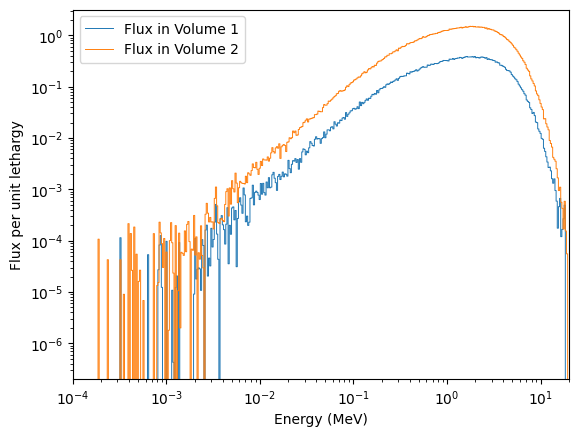

In [12]:
# Retrieve and print the shape of the flux spectrum scores
print(f"Shape of FluxSpectrumAllVolumes: {flux_all_volumes.shape}")

# Access and print the mean and variance of the flux spectrum scores
mean_flux = flux_all_volumes.mean

# Create an energy grid for plotting
energies = np.logspace(-11, np.log10(20), 1001)  # Energy grid for one volume

# Plot the mean flux spectrum per unit lethargy for each volumes
flux_per_lethargy = mean_flux / np.ediff1d(np.log(energies))

# plot only the inner and outer sphere and not the outside volume (where the flux is null)
for i in range(geo.nb_volumes - 1):
    plt.plot(
        energies[:-1],
        flux_per_lethargy[i, :],
        linestyle="-",
        linewidth=0.7,
        drawstyle="steps-post",
        label=f"Flux in Volume {i+1}",
    )

# Set plot labels and scales
plt.xlabel("Energy (MeV)")
plt.ylabel("Flux per unit lethargy")
plt.xlim(1e-4, 20)
plt.xscale("log")
plt.yscale("log")
plt.legend()

### MT Reaction Rate Score Results
    
The shape of `MTReactionRate` is defined by three dimensions: the number of volumes, the number of energy groups, and the number of MT reaction rates.

Here we plot reaction rates for the inner sphere only


Shape of MTReactionRate: [3, 1000, 3]


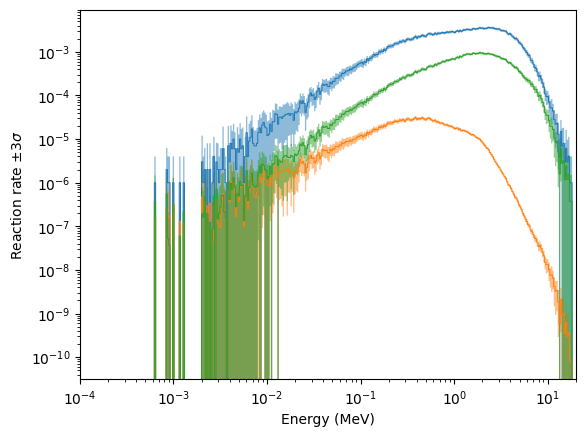

In [13]:
print(f"Shape of MTReactionRate: {mt_reaction_rate.shape}")
mean_mt_reaction_rate = mt_reaction_rate.mean
std_mt_reaction_rate = np.sqrt(mt_reaction_rate.var)

energy_bounds = mt_reaction_rate.energy_bounds
vol_index = 0
for mt_index, mt in enumerate([1, 102, 18]):
    plt.plot(
        energy_bounds[:-1],
        mean_mt_reaction_rate[vol_index, :, mt_index],
        linestyle="-",
        linewidth=0.7,
        drawstyle="steps-post",
        label=f"(MT = {mt} in volume {vol_index+1})",
    )
    plt.fill_between(
        energy_bounds[:-1],
        mean_mt_reaction_rate[0, :, mt_index]
        - 3 * std_mt_reaction_rate[0, :, mt_index],
        mean_mt_reaction_rate[0, :, mt_index]
        + 3 * std_mt_reaction_rate[0, :, mt_index],
        alpha=0.5,
        step="post",
    )
plt.xlabel("Energy (MeV)")
plt.ylabel(r"Reaction rate $\pm 3 \sigma$")
plt.xlim(1e-4, 20)
plt.xscale("log")
plt.yscale("log")

### Mesh-Based Score Results

For Mesh-Based scores, two additional methods are available: `writeFieldToVTKFile` and `writeToMEDFile`. These methods allow you to write the scores to VTK files and MED file, respectively. These files can then be used to visualize the scores using CAD tools.

In [14]:
# Write the mean field to a VTK file
kappa_fission_mesh.writeFieldToVTKFile(file_path="kappa_fission_mean.vtk", field="mean")

# Write the mean standard deviation field to a VTK file
kappa_fission_mesh.writeFieldToVTKFile(
    file_path="kappa_fission_mean_std.vtk", field="meanstd"
)
# Write the results to a MED file
kappa_fission_mesh.writeToMEDFile(file_path="kappa_fission.med")

# Read all fields from the MED file
fields = mc.MEDFileFields.New("kappa_fission.med")

# Get the names of all fields in the MED file
field_names = fields.getFieldsNames()

# Print the list of field names
print("Fields in the MED file:", field_names)

Fields in the MED file: ('_neutron_simulation_scores_KappaFissionMEDMesh_Mean', '_neutron_simulation_scores_KappaFissionMEDMesh_MeanStd')


When using the `writeToFile` method with mesh-based scores, the `volume_rank` column refers to the cell rank of the MED mesh, not to the geometry volumes.

The dimension of the shape of the mesh-based scores corresponds to the number of energy bins multiplied by the number of cells in the MED mesh.  
We plot the 90th group at the 5th $z$-level cut ending up with an X-Y map.

**Important:** note that the MEDCouplingMesh indexing is $z,y,x$. Numpy [swapaxes](https://numpy.org/doc/2.1/reference/generated/numpy.swapaxes.html) or [transpose](https://bic-berkeley.github.io/psych-214-fall-2016/numpy_transpose.html) allows retrieving a more conventional order.

Shape of KappaFissionMEDMesh: [9, 9, 9, 100]


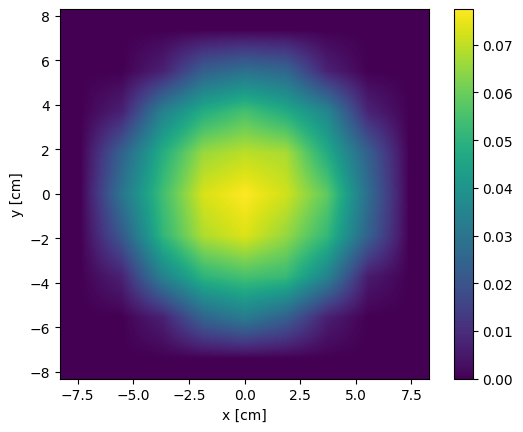

In [15]:
# Retrieve and print the shape of the mesh-based scores
shape_kappa_fission_mesh = kappa_fission_mesh.shape
print(f"Shape of KappaFissionMEDMesh: {shape_kappa_fission_mesh}")
mean = kappa_fission_mesh.mean
mean = np.swapaxes(mean, 0, 2)
plt.imshow(
    mean[:, :, 4, 90],
    origin="lower",
    interpolation="bilinear",
    extent=(xarr[0], xarr[-1], yarr[0], yarr[-1]),
)
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.colorbar()